In [1]:
# When using JupyterLab running on mybinder.org (https://jupyter.org/try), remember to choose "Python 3" kernel
# Current xeus-python kernel version in this environment does not support Matplotlib and magic commands

In [2]:
# Check version of modules which will be used in this project
# https://unix.stackexchange.com/questions/47918/how-to-grep-a-specific-line-and-the-first-line-of-a-file
# https://www.setouchino.cloud/blogs/108
!pip3 list | awk 'NR <= 2 || /bokeh/ || /matplotlib/ || /numpy/ || /pandas/'

Package                       Version
----------------------------- -----------
bokeh                         2.4.1
matplotlib                    3.1.3
matplotlib-inline             0.1.3
numpy                         1.21.2
pandas                        1.3.3


In [3]:
# Check version of Jupyter components
!jupyter --version

Selected Jupyter core packages...
IPython          : 7.28.0
ipykernel        : 5.1.4
ipywidgets       : 7.6.3
jupyter_client   : 7.0.6
jupyter_core     : 4.8.1
jupyter_server   : 1.11.1
jupyterlab       : 3.2.0
nbclient         : 0.5.4
nbconvert        : 6.0.7
nbformat         : 5.1.3
notebook         : 6.3.0
qtconsole        : not installed
traitlets        : 5.1.0


In [4]:
import numpy as np
import pandas as pd

In [5]:
# (Optional) Enable Matplotlib Auto-show feature in Jupyter Notebooks
# Without this magic command, you will need to call show() method explicitly to display your plot
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html#matplotlib.pyplot.show
#%matplotlib inline

In [6]:
# WARNING - DO NOT SET THESE OPTIONS TO "NONE" UNLESS YOU ARE TRYING TO PRINT A SMALL DATAFRAME ON SCREEN
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [7]:
# Load exported CSV files into Pandas DataFrames
# Remember to upload CSV files to your JupyterLab before running this code block
df_city_list = pd.read_csv('results_city_list.csv')
df_raw_global = pd.read_csv('results_global_data.csv')
df_raw_city_all = pd.read_csv('results_city_data.csv')

In [8]:
# Rename column to distinguish global avg_temp from local avg_temp
df_raw_global.columns = ['year', 'avg_temp_global']
df_raw_city_all.columns = ['year', 'city', 'country', 'avg_temp_local']

In [9]:
# Create an interactive menu interface to accept user inputs, and deploy mechanisms to handle invalid inputs
while True:
    choice_char_country = input("Enter the initial letter of the country you want to analyze (only [a-z], [A-Z] allowed): ")
    if choice_char_country.isalpha() == False:
        print('Not a character. Please try again.')
        continue
    elif len(choice_char_country) != 1:
        print('Invalid user input. Please try again.')
        continue
    # 'O', 'W', 'X', 'Y' will return empty country list
    elif len(df_city_list.query('country.str.startswith(@choice_char_country.upper(), na=False)').country.sort_values().unique().tolist()) == 0:
        print('No country name starts with this letter. Please enter another initial letter.')
        continue
    else:
        country_list_temp = df_city_list.query('country.str.startswith(@choice_char_country.upper(), na=False)').country.sort_values().unique().tolist()
        break

print("Following is the list of country name(s) with an initial letter {}:".format(choice_char_country.upper()))
for country in country_list_temp:
    print('({}) {}'.format(country_list_temp.index(country), country))

while True:
    choice_country = input("Choose the country you want to analyze (only [0-9] allowed): ")
    if choice_country.isnumeric() == False:
        print('Not a number. Please try again.')
        continue
    elif int(choice_country) > len(country_list_temp) - 1:
        print('Invalid country choice. Please try again.')
        continue
    else:
        selected_country = country_list_temp[int(choice_country)]
        city_list_temp = df_city_list.loc[df_city_list['country'] == country_list_temp[int(choice_country)]].city.sort_values().unique().tolist()
        break

print("Following is the list of city name(s) available in {}:".format(country_list_temp[int(choice_country)]))
for city in city_list_temp:
    print('({}) {}'.format(city_list_temp.index(city), city))

while True:
    choice_city = input("Choose the city you want to analyze (only [0-9] allowed): ")
    if choice_city.isnumeric() == False:
        print('Not a number. Please try again.')
        continue
    elif int(choice_city) > len(city_list_temp) - 1:
        print('Invalid city choice. Please try again.')
        continue
    else:
        selected_city = city_list_temp[int(choice_city)]
        break


Enter the initial letter of the country you want to analyze (only [a-z], [A-Z] allowed):  j


Following is the list of country name(s) with an initial letter J:
(0) Jamaica
(1) Japan


Choose the country you want to analyze (only [0-9] allowed):  1


Following is the list of city name(s) available in Japan:
(0) Hiroshima
(1) Kawasaki
(2) Kitakyushu
(3) Kobe
(4) Nagoya
(5) Tokyo


Choose the city you want to analyze (only [0-9] allowed):  5


In [10]:
print('The country of your choice is:', selected_country)
print('The city of your choice is:', selected_city)

The country of your choice is: Japan
The city of your choice is: Tokyo


In [11]:
# Extract only rows containing selected city and country from the whole city data
df_selected_city = df_raw_city_all.loc[(df_raw_city_all['city'] == selected_city) & (df_raw_city_all['country'] == selected_country)]

In [12]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html

# Combine global data and local city data into a single DataFrame
# Use inner join to align year range of global data with city level data
df_combined = pd.merge(df_raw_global, df_selected_city, how="inner", on='year')

# Reset DataFrame index (row number)
df_combined.reset_index(drop=True, inplace=True)

In [13]:
# https://www.kite.com/python/answers/how-to-find-the-moving-average-of-a-list-in-python
# https://medium.com/analytics-vidhya/how-to-calculate-a-moving-average-using-pandas-for-python-d19415bebc7d
# https://www.absentdata.com/pandas/python-moving-average/

# Calculate 10-year MA of avg_temp and append these computed columns to DataFrame
ma_window_size = 10
df_combined['{}_year_ma_global'.format(ma_window_size)] = df_combined.rolling(window=ma_window_size, min_periods=1).avg_temp_global.mean()
df_combined['{}_year_ma_local'.format(ma_window_size)] = df_combined.rolling(window=ma_window_size, min_periods=1).avg_temp_local.mean()

# Delete MA values which do not conform to window size (MA values that shouldn't be generated when using Excel/Google Sheet)
for i in range(0, (ma_window_size-1), 1):
    df_combined.loc[i, ['10_year_ma_global', '10_year_ma_local']] = None

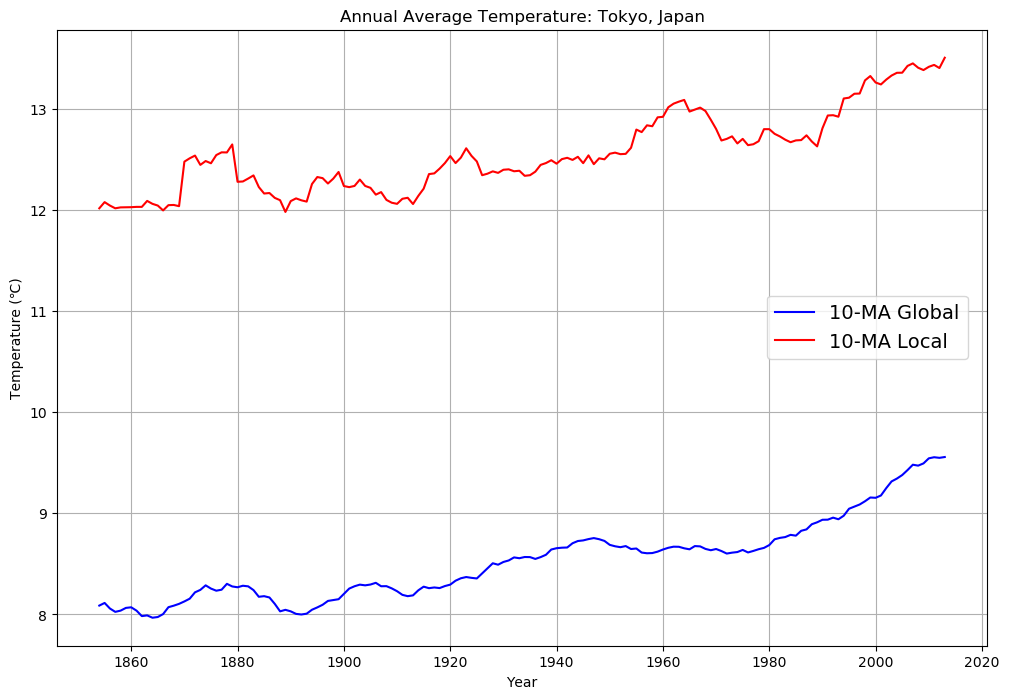

In [14]:
# Use the combined DataFrame to create a line plot which contains both global and local avg_temp in MA
# Examples of Matplotlib line plots referenced
# https://datatofish.com/plot-dataframe-pandas/
# https://realpython.com/pandas-plot-python/

import matplotlib
import matplotlib.pyplot as plt

# Create a line plot with both global and city level data displayed
df_combined.plot(x='year', y=['10_year_ma_global', '10_year_ma_local'], color=['blue', 'red'], kind='line', figsize=(12,8))

# Customization of the line plot
plt.title('Annual Average Temperature: {}, {}'.format(selected_city, selected_country))
plt.xlabel('Year')
plt.ylabel('Temperature (℃)')
plt.grid()
# Legend location of the line plot needs more care
# https://stackoverflow.com/questions/33149428/modify-the-legend-of-pandas-bar-plot/33150133
# https://qiita.com/matsui-k20xx/items/291400ed56a39ed63462
plt.legend(['10-MA Global', '10-MA Local'], loc='best', bbox_to_anchor=(1.0, 0.6), borderaxespad=1, fontsize=14)

# (Optional) Save the line plot to a file
plt.savefig("10-year-MA_{}_{}.png".format(selected_country, selected_city))

# Show the line plot in Jupyter Notebook
plt.show()

In [15]:
# Because Matplotlib can only produce static plots (in JupyterLab), it may not be as convenient as expected
# We will try to create an interactive plot with the least effort to assist us in visualizing weather trends
# We choose to use Bokeh because it is already installed on JupyterLab running on mybinder.org

# Examples of Bokeh line plots referenced
# https://programminghistorian.org/en/lessons/visualizing-with-bokeh
# https://thedatafrog.com/en/articles/interactive-visualization-bokeh-jupyter/
# https://stackoverflow.com/questions/54413574/how-do-i-make-a-line-graph-from-a-dataframe-in-bokeh
# https://trenton3983.github.io/files/projects/2020-03-15_interactive_data_visualization_with_bokeh/2020-03-15_interactive_data_visualization_with_bokeh.html
# (see Section 2.4 Annotations and guides)

# Plotting directly with Bokeh is already sufficient for this project
# However, if you want to use Bokeh as a Pandas/Pyspark plotting backend, you can install Pandas-Bokeh
# https://www.kaggle.com/pavansanagapati/pandas-bokeh-visualization-tutorial
# https://github.com/PatrikHlobil/Pandas-Bokeh

from bokeh.io import output_notebook, output_file, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.models.tools import CrosshairTool, HoverTool
from bokeh.models.widgets import Panel, Tabs

In [16]:
# Use Pandas DataFrame as a Bokeh data source
source = ColumnDataSource(df_combined)

# Define the size of Bokeh plot
p1 = figure(plot_height=600, plot_width=800)

# Create a line plot with both global and city level data displayed
p1.line(x='year', y='10_year_ma_global', color='blue', source=source, legend_label='10-MA Global')
p1.line(x='year', y='10_year_ma_local', color='red', source=source, legend_label='10-MA Local')

# Customization of the line plot
p1.title.text = 'Annual Average Temperature: {}, {}'.format(selected_city, selected_country)
p1.xaxis.axis_label = 'Year'
p1.yaxis.axis_label = 'Temperature (℃)'

# Since p1 is a plot which contains line charts of both global and local data, you may need to change the location of legend to make your plot better-looking
#p1.legend.location = "bottom_right"
p1.legend.location = "right"

# Bokeh has a nice feature called "tabs", which can let you switch between plots to make visualization user-friendlier
# https://stackoverflow.com/questions/54731483/bokeh-widget-to-switch-between-figures-plots
# http://docs.bokeh.org/en/latest/docs/user_guide/interaction/widgets.html#tabs
tab1 = Panel(child=p1, title="Global and Local")

In [17]:
# Repeat steps of p1 to create a line plot with ONLY global data displayed
p2 = figure(plot_height=600, plot_width=800)

p2.line(x='year', y='10_year_ma_global', color='blue', source=source, legend_label='10-MA Global')

p2.title.text = 'Annual Average Temperature: {}, {}'.format(selected_city, selected_country)
p2.xaxis.axis_label = 'Year'
p2.yaxis.axis_label = 'Temperature (℃)'

p2.legend.location = "bottom_right"

tab2 = Panel(child=p2, title="Global Only")

In [18]:
# Repeat steps of p1 to create a line plot with ONLY city level data displayed
p3 = figure(plot_height=600, plot_width=800)

p3.line(x='year', y='10_year_ma_local', color='red', source=source, legend_label='10-MA Local')

p3.title.text = 'Annual Average Temperature: {}, {}'.format(selected_city, selected_country)
p3.xaxis.axis_label = 'Year'
p3.yaxis.axis_label = 'Temperature (℃)'

p3.legend.location = "bottom_right"

tab3 = Panel(child=p3, title="Local Only")

In [19]:
# Make use of Bokeh plot tools to enhance our final plot
# https://docs.bokeh.org/en/latest/docs/user_guide/tools.html
# Read the following sections in this URL:
# Inspectors -> CrosshairTool
# Inspectors -> HoverTool -> Basic Tooltips, Hit-Testing behavior

# Create a tooltip to display labels and values when hovering over a plot
hover1 = HoverTool(
    tooltips=[
        ('Year', '@year'),
        ('10-MA Global', '@10_year_ma_global'),
        ('10-MA Local', '@10_year_ma_local')
    ],
    # use mode 'vline' instead of 'mouse' (default)
    mode='vline'
)
hover2 = HoverTool(
    tooltips=[
        ('Year', '@year'),
        ('10-MA Global', '@10_year_ma_global')
    ],
    mode='vline'
)
hover3 = HoverTool(
    tooltips=[
        ('Year', '@year'),
        ('10-MA Local', '@10_year_ma_local')
    ],
    mode='vline'
)

# Use CrosshairTool to enable a sliding-bar like user experience
crosshair = CrosshairTool()

# Add these defined tools to Bokeh plot
p1.add_tools(hover1, crosshair)
p2.add_tools(hover2, crosshair)
p3.add_tools(hover3, crosshair)

In [20]:
# Save the plot we created to a HTML file for future reference, and show it in Jupyter notebook
# https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html
# https://docs.bokeh.org/en/latest/docs/first_steps/first_steps_7.html

# (Optional) Save the line plot to a file
output_file('10-year-MA_{}_{}.html'.format(selected_country, selected_city))

# Enable Jupyter Notebook to display the line plot
output_notebook()

# Create a tabbed layout in the final plot
tabs = Tabs(tabs=[tab1, tab2, tab3])

# Show the line plot in Jupyter Notebook
show(tabs)

Loading BokehJS ...